영상을 입력해서 수치를 예측하는 모델들에 대해서 알아보겠습니다. 간단한 테스트를 위해 수치예측을 위한 영상 데이터셋 생성을 해보고, 다층퍼셉트론 및 컨볼루션 신경망 모델을 구성 및 학습 시켜보겠습니다. 이 모델은 고정된 지역에서 촬영된 영상으로부터 복잡도, 밀도 등을 수치화하는 문제를 풀 수 있습니다. 아래 문제들에 활용 기대해봅니다.
* CCTV 등 촬영 영상으로부터 미세먼지 지수 예측
* 위성영상으로부터 녹조, 적조 등의 지수 예측
* 태양광 패널의 먼지가 쌓여있는 정도 예측

---
### 데이터셋 준비

너비가 16, 높이가 16이고, 픽셀값을 0과 1을 가지는 영상을 만들어보겠습니다. 임의의 값이 주어지면, 그 값만큼 반복하여 영상 내에 1인 픽셀을 찍었습니다. 여기서 임의의 값이 라벨값으로 지정했습니다.

In [1]:
width = 16
height = 16

def generate_dataset(samples):

    ds_x = []
    ds_y = []
    
    for it in range(samples):
        
        num_pt = np.random.randint(0, width * height)
        img = generate_image(num_pt)
        
        ds_y.append(num_pt)
        ds_x.append(img)
    
    return np.array(ds_x), np.array(ds_y).reshape(samples, 1)
    
def generate_image(points):
    
    img = np.zeros((width, height))
    pts = np.random.random((points, 2))
    
    for ipt in pts:
        img[int(ipt[0] * width), int(ipt[1] * height)] = 1
    
    return img.reshape(width, height, 1)

데이터셋으로 훈련셋을 1500개, 검증셋을 300개, 시험셋을 100개 생성합니다.

In [2]:
x_train, y_train = generate_dataset(1500)
x_val, y_val = generate_dataset(300)
x_test, y_test = generate_dataset(100)

만든 데이터셋 일부를 가시화 해보겠습니다.

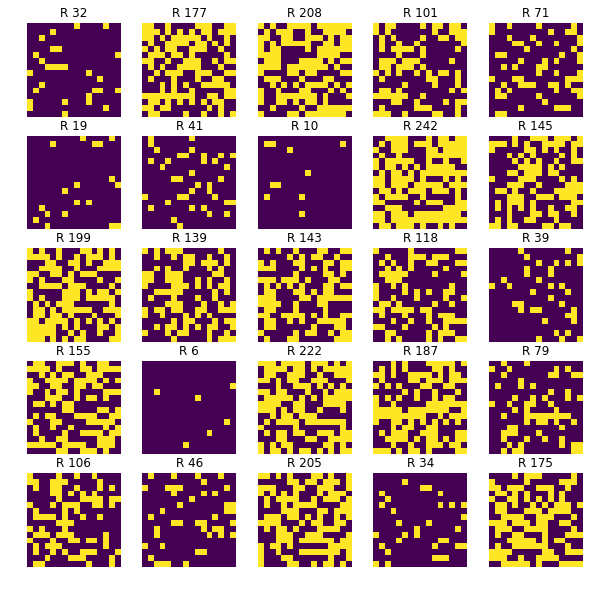

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
        
plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):
    sub_plt = axarr[i/plt_row, i%plt_col]
    sub_plt.axis('off')
    sub_plt.imshow(x_train[i].reshape(width, height))
    sub_plt.set_title('R ' + str(y_train[i][0]))

plt.show()

![img](http://tykimos.github.com/Keras/warehouse/2017-8-20-Image_Input_Numerical_Prediction_Model_Recipe_output_7_0.png)

R(Real)은 1인 값을 가진 픽셀 수를 의미합니다. 한 번 표시한 픽셀에 다시 표시가 될 수 있기 때문에 실제 픽셀 수와 조금 차이는 날 수 있습니다.

---
### 레이어 준비

영상입력 수치예측 모델에서 사용할 레이어는 다음과 같습니다. 

|종류|구분|상세구분|브릭|비고|
|:-:|:-:|:-:|:-:|:-:|
|데이터셋|1D|-|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_Dataset_Vector_s.png)|MLP 모델 입력과 출력, CNN 모델 출력으로 사용|
|데이터셋|2D|-|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_Dataset2D_s.png)|CNN 모델 입력으로 2D 영상데이터 입력|
|레이어|Dense|-|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_Dense_s.png)|MLP 모델이나 CNN 모델의 FC에 사용|
|레이어|Conv2D|-|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_Conv2D_s.png)|CNN 모델에 사용|
|레이어|MaxPooling2D|-|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_MaxPooling2D_s.png)|CNN 모델에 사용|
|레이어|Flatten|-|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_Flatten_s.png)|CNN 모델에서 FC 연결용으로 사용|
|레이어|Activation|relu|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_Activation_Relu_s.png)|Dense 레이어의 은닉층에 사용|
|레이어|Activation|relu|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_Activation_relu_2D_s.png)|Conv2D 레이어의 은닉층에 사용|
|레이어|Activation|sigmoid|![img](http://tykimos.github.com/Keras/warehouse/DeepBrick/Model_Recipe_Part_Activation_sigmoid_s.png)|이진분류 모델의 출력층에 사용|

---
### 모델 준비

영상입력 수치예측을 하기 위해 `다층퍼셉트론 신경망 모델`, `컨볼루션 신경망 모델`을 준비했습니다.

#### 다층퍼셉트론 신경망 모델

    model = Sequential()
    model.add(Dense(256, activation='relu', input_dim = width*height))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256))
    model.add(Dense(1))
    
![img](http://tykimos.github.com/Keras/warehouse/2017-8-20-Image_Input_Numerical_Prediction_Model_Recipe_1m.png)

#### 컨볼루션 신경망 모델

    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(1))
    
![img](http://tykimos.github.com/Keras/warehouse/2017-8-20-Image_Input_Numerical_Prediction_Model_Recipe_2m.png)    

---
### 전체 소스

앞서 살펴본 `다층퍼셉트론 신경망 모델`, `컨볼루션 신경망 모델`의 전체 소스는 다음과 같습니다. 

#### 다층퍼셉트론 신경망 모델

Train on 1500 samples, validate on 300 samples
Epoch 1/1000
1500/1500 [==============================] - 1s - loss: 4547.2297 - val_loss: 489.0028
Epoch 2/1000
1500/1500 [==============================] - 0s - loss: 270.5862 - val_loss: 250.0564
Epoch 3/1000
1500/1500 [==============================] - 0s - loss: 184.1776 - val_loss: 200.3438
Epoch 4/1000
1500/1500 [==============================] - 0s - loss: 122.8675 - val_loss: 180.7739
Epoch 5/1000
1500/1500 [==============================] - 0s - loss: 90.6016 - val_loss: 136.7174
Epoch 6/1000
1500/1500 [==============================] - 0s - loss: 63.9597 - val_loss: 146.0529
Epoch 7/1000
1500/1500 [==============================] - 0s - loss: 53.5830 - val_loss: 124.3205
Epoch 8/1000
1500/1500 [==============================] - 0s - loss: 37.8022 - val_loss: 117.1254
Epoch 9/1000
1500/1500 [==============================] - 0s - loss: 28.3289 - val_loss: 124.8042
Epoch 10/1000
1500/1500 [==============================] - 0s - lo

1500/1500 [==============================] - 0s - loss: 0.6115 - val_loss: 110.7151
Epoch 166/1000
1500/1500 [==============================] - 0s - loss: 0.4471 - val_loss: 109.9399
Epoch 167/1000
1500/1500 [==============================] - 0s - loss: 0.4056 - val_loss: 109.4034
Epoch 168/1000
1500/1500 [==============================] - 0s - loss: 0.6432 - val_loss: 110.3886
Epoch 169/1000
1500/1500 [==============================] - 0s - loss: 0.4799 - val_loss: 109.5534
Epoch 170/1000
1500/1500 [==============================] - 0s - loss: 0.7905 - val_loss: 109.0944
Epoch 171/1000
1500/1500 [==============================] - 0s - loss: 1.3238 - val_loss: 109.5127
Epoch 172/1000
1500/1500 [==============================] - 0s - loss: 0.9553 - val_loss: 109.2368
Epoch 173/1000
1500/1500 [==============================] - 0s - loss: 0.5171 - val_loss: 109.4849
Epoch 174/1000
1500/1500 [==============================] - 0s - loss: 0.5318 - val_loss: 108.9721
Epoch 175/1000
1500/1500 

1500/1500 [==============================] - 0s - loss: 2.1297 - val_loss: 108.5330
Epoch 330/1000
1500/1500 [==============================] - 0s - loss: 3.8004 - val_loss: 108.6759
Epoch 331/1000
1500/1500 [==============================] - 0s - loss: 1.2450 - val_loss: 111.7669
Epoch 332/1000
1500/1500 [==============================] - 0s - loss: 2.1443 - val_loss: 113.9407
Epoch 333/1000
1500/1500 [==============================] - 0s - loss: 2.8668 - val_loss: 110.3447
Epoch 334/1000
1500/1500 [==============================] - 0s - loss: 1.4103 - val_loss: 113.4196
Epoch 335/1000
1500/1500 [==============================] - 0s - loss: 3.1951 - val_loss: 114.2707
Epoch 336/1000
1500/1500 [==============================] - 0s - loss: 3.1737 - val_loss: 110.1802
Epoch 337/1000
1500/1500 [==============================] - 0s - loss: 2.6943 - val_loss: 108.1605
Epoch 338/1000
1500/1500 [==============================] - 0s - loss: 2.3952 - val_loss: 112.4822
Epoch 339/1000
1500/1500 

1500/1500 [==============================] - 0s - loss: 0.2051 - val_loss: 107.0124
Epoch 494/1000
1500/1500 [==============================] - 0s - loss: 0.2096 - val_loss: 107.8600
Epoch 495/1000
1500/1500 [==============================] - 0s - loss: 0.1257 - val_loss: 108.8176
Epoch 496/1000
1500/1500 [==============================] - 0s - loss: 0.2425 - val_loss: 107.6054
Epoch 497/1000
1500/1500 [==============================] - 0s - loss: 0.1526 - val_loss: 107.2814
Epoch 498/1000
1500/1500 [==============================] - 0s - loss: 0.1137 - val_loss: 107.0894
Epoch 499/1000
1500/1500 [==============================] - 0s - loss: 0.0778 - val_loss: 107.8400
Epoch 500/1000
1500/1500 [==============================] - 0s - loss: 0.1176 - val_loss: 106.8309
Epoch 501/1000
1500/1500 [==============================] - 0s - loss: 0.1710 - val_loss: 107.6460
Epoch 502/1000
1500/1500 [==============================] - 0s - loss: 0.1367 - val_loss: 107.6132
Epoch 503/1000
1500/1500 

1500/1500 [==============================] - 0s - loss: 0.5756 - val_loss: 108.5122
Epoch 658/1000
1500/1500 [==============================] - 0s - loss: 0.3031 - val_loss: 107.8349
Epoch 659/1000
1500/1500 [==============================] - 0s - loss: 0.2534 - val_loss: 107.9893
Epoch 660/1000
1500/1500 [==============================] - 0s - loss: 0.2793 - val_loss: 110.6836
Epoch 661/1000
1500/1500 [==============================] - 0s - loss: 0.1526 - val_loss: 109.5915
Epoch 662/1000
1500/1500 [==============================] - 0s - loss: 0.2468 - val_loss: 109.0506
Epoch 663/1000
1500/1500 [==============================] - 0s - loss: 0.1652 - val_loss: 108.2142
Epoch 664/1000
1500/1500 [==============================] - 0s - loss: 0.5019 - val_loss: 108.4376
Epoch 665/1000
1500/1500 [==============================] - 0s - loss: 0.6537 - val_loss: 108.5771
Epoch 666/1000
1500/1500 [==============================] - 0s - loss: 0.6028 - val_loss: 111.3235
Epoch 667/1000
1500/1500 

1500/1500 [==============================] - 0s - loss: 0.0799 - val_loss: 107.7969
Epoch 822/1000
1500/1500 [==============================] - 0s - loss: 0.0457 - val_loss: 108.0757
Epoch 823/1000
1500/1500 [==============================] - 0s - loss: 0.0451 - val_loss: 107.2879
Epoch 824/1000
1500/1500 [==============================] - 0s - loss: 0.0871 - val_loss: 108.4794
Epoch 825/1000
1500/1500 [==============================] - 0s - loss: 0.1160 - val_loss: 108.0785
Epoch 826/1000
1500/1500 [==============================] - 0s - loss: 0.1231 - val_loss: 106.9747
Epoch 827/1000
1500/1500 [==============================] - 0s - loss: 0.1792 - val_loss: 109.2438
Epoch 828/1000
1500/1500 [==============================] - 0s - loss: 0.3291 - val_loss: 107.6228
Epoch 829/1000
1500/1500 [==============================] - 0s - loss: 1.5361 - val_loss: 108.7926
Epoch 830/1000
1500/1500 [==============================] - 0s - loss: 3.3586 - val_loss: 112.8671
Epoch 831/1000
1500/1500 

1500/1500 [==============================] - 0s - loss: 4.5998 - val_loss: 108.6853
Epoch 986/1000
1500/1500 [==============================] - 0s - loss: 4.4934 - val_loss: 113.0420: 5.15
Epoch 987/1000
1500/1500 [==============================] - 0s - loss: 1.8077 - val_loss: 112.0368
Epoch 988/1000
1500/1500 [==============================] - 0s - loss: 1.3173 - val_loss: 112.8661
Epoch 989/1000
1500/1500 [==============================] - 0s - loss: 0.7971 - val_loss: 109.2341
Epoch 990/1000
1500/1500 [==============================] - 0s - loss: 0.3934 - val_loss: 111.1157
Epoch 991/1000
1500/1500 [==============================] - 0s - loss: 0.5586 - val_loss: 107.9663
Epoch 992/1000
1500/1500 [==============================] - 0s - loss: 0.2761 - val_loss: 106.9580
Epoch 993/1000
1500/1500 [==============================] - 0s - loss: 0.1219 - val_loss: 107.0053
Epoch 994/1000
1500/1500 [==============================] - 0s - loss: 0.1215 - val_loss: 107.5465
Epoch 995/1000
1500

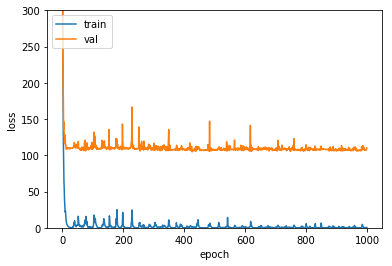

 32/100 [========>.....................] - ETA: 0s110.12584671


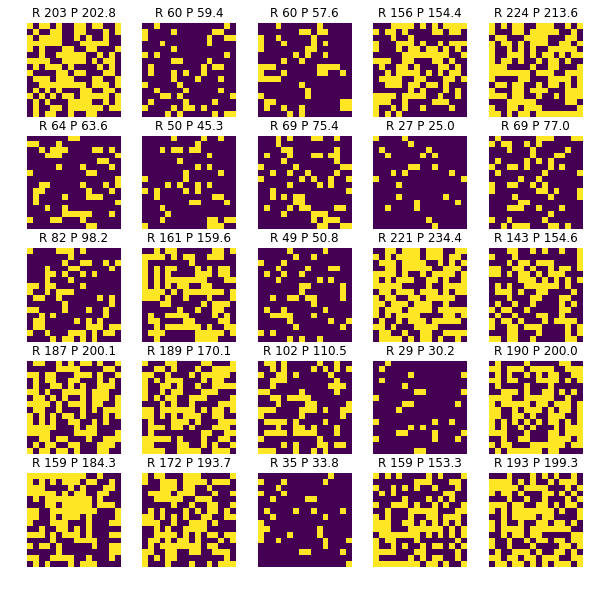

In [8]:
# 0. 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense

width = 16
height = 16

def generate_dataset(samples):

    ds_x = []
    ds_y = []
    
    for it in range(samples):
        
        num_pt = np.random.randint(0, width * height)
        img = generate_image(num_pt)
        
        ds_y.append(num_pt)
        ds_x.append(img)
    
    return np.array(ds_x), np.array(ds_y).reshape(samples, 1)
    
def generate_image(points):
    
    img = np.zeros((width, height))
    pts = np.random.random((points, 2))
    
    for ipt in pts:
        img[int(ipt[0] * width), int(ipt[1] * height)] = 1
    
    return img.reshape(width, height, 1)

# 1. 데이터셋 생성하기
x_train, y_train = generate_dataset(1500)
x_val, y_val = generate_dataset(300)
x_test, y_test = generate_dataset(100)

x_train_1d = x_train.reshape(x_train.shape[0], width*height)
x_val_1d = x_val.reshape(x_val.shape[0], width*height)
x_test_1d = x_test.reshape(x_test.shape[0], width*height)

# 2. 모델 구성하기
model = Sequential()
model.add(Dense(256, activation='relu', input_dim = width*height))
model.add(Dense(256, activation='relu'))
model.add(Dense(256))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mse', optimizer='adam')

# 5. 모델 학습시키기
hist = model.fit(x_train_1d, y_train, batch_size=32, epochs=1000, validation_data=(x_val_1d, y_val))

# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim(0.0, 300.0)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 7. 모델 평가하기
score = model.evaluate(x_test_1d, y_test, batch_size=32)

print(score)

# 8. 모델 사용하기
yhat_test = model.predict(x_test_1d, batch_size=32)

%matplotlib inline
import matplotlib.pyplot as plt

plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):
    sub_plt = axarr[i/plt_row, i%plt_col]
    sub_plt.axis('off')
    sub_plt.imshow(x_test[i].reshape(width, height))
    sub_plt.set_title('R %d P %.1f' % (y_test[i][0], yhat_test[i][0]))

plt.show()

다층퍼셉트론 모델의 입력층인 Dense 레이어는 일차원 벡터로 데이터를 입력 받기 때문에, 이차원인 영상을 일차원 벡터로 변환하는 과정이 필요합니다.

In [7]:
x_train_1d = x_train.reshape(x_train.shape[0], width*height)
x_val_1d = x_val.reshape(x_val.shape[0], width*height)
x_test_1d = x_test.reshape(x_test.shape[0], width*height)

예측 결과 일부를 표시해봤습니다. R(Real)이 실제 값이고, P(Prediction)이 모델이 예측한 결과입니다. 출력층에 따로 활성화 함수를 지정하지 않았기 때문에 선형 함수가 사용되며, 정수가 아닌 실수로 예측됩니다. 

![img](http://tykimos.github.com/Keras/warehouse/2017-8-20-Image_Input_Numerical_Prediction_Model_Recipe_output_13_4.png)

#### 컨볼루션 신경망 모델

Train on 1500 samples, validate on 300 samples
Epoch 1/1000
1500/1500 [==============================] - 0s - loss: 12420.6872 - val_loss: 1761.2949
Epoch 2/1000
1500/1500 [==============================] - 0s - loss: 1472.7157 - val_loss: 1186.2057
Epoch 3/1000
1500/1500 [==============================] - 0s - loss: 1060.2265 - val_loss: 901.6347
Epoch 4/1000
1500/1500 [==============================] - 0s - loss: 796.7482 - val_loss: 654.8258
Epoch 5/1000
1500/1500 [==============================] - 0s - loss: 550.1788 - val_loss: 431.6627
Epoch 6/1000
1500/1500 [==============================] - 0s - loss: 365.2321 - val_loss: 307.5278
Epoch 7/1000
1500/1500 [==============================] - 0s - loss: 287.3712 - val_loss: 281.2053
Epoch 8/1000
1500/1500 [==============================] - 0s - loss: 295.8835 - val_loss: 310.7699
Epoch 9/1000
1500/1500 [==============================] - 0s - loss: 260.4724 - val_loss: 272.0658
Epoch 10/1000
1500/1500 [==============================]

1500/1500 [==============================] - 0s - loss: 4.9565 - val_loss: 167.2225
Epoch 165/1000
1500/1500 [==============================] - 0s - loss: 4.8922 - val_loss: 163.3288
Epoch 166/1000
1500/1500 [==============================] - 0s - loss: 4.9226 - val_loss: 165.6444
Epoch 167/1000
1500/1500 [==============================] - 0s - loss: 4.1370 - val_loss: 164.2639
Epoch 168/1000
1500/1500 [==============================] - 0s - loss: 4.4773 - val_loss: 167.3552
Epoch 169/1000
1500/1500 [==============================] - 0s - loss: 4.8959 - val_loss: 166.3317
Epoch 170/1000
1500/1500 [==============================] - 0s - loss: 4.2462 - val_loss: 167.8196
Epoch 171/1000
1500/1500 [==============================] - 0s - loss: 4.0468 - val_loss: 167.5952
Epoch 172/1000
1500/1500 [==============================] - 0s - loss: 6.5043 - val_loss: 170.2509
Epoch 173/1000
1500/1500 [==============================] - 0s - loss: 3.3499 - val_loss: 167.0916
Epoch 174/1000
1500/1500 

1500/1500 [==============================] - 0s - loss: 4.8402 - val_loss: 178.1067
Epoch 329/1000
1500/1500 [==============================] - 0s - loss: 2.3101 - val_loss: 176.2716
Epoch 330/1000
1500/1500 [==============================] - 0s - loss: 2.6461 - val_loss: 173.4393
Epoch 331/1000
1500/1500 [==============================] - 0s - loss: 0.9173 - val_loss: 179.1287
Epoch 332/1000
1500/1500 [==============================] - 0s - loss: 0.5933 - val_loss: 183.0035
Epoch 333/1000
1500/1500 [==============================] - 0s - loss: 1.0512 - val_loss: 180.1778
Epoch 334/1000
1500/1500 [==============================] - 0s - loss: 1.4834 - val_loss: 177.5273
Epoch 335/1000
1500/1500 [==============================] - 0s - loss: 2.0577 - val_loss: 181.5051
Epoch 336/1000
1500/1500 [==============================] - 0s - loss: 1.7183 - val_loss: 179.0406
Epoch 337/1000
1500/1500 [==============================] - 0s - loss: 0.8441 - val_loss: 177.5168
Epoch 338/1000
1500/1500 

1500/1500 [==============================] - 0s - loss: 0.4878 - val_loss: 177.3484
Epoch 493/1000
1500/1500 [==============================] - 0s - loss: 0.5441 - val_loss: 177.2194
Epoch 494/1000
1500/1500 [==============================] - 0s - loss: 0.5063 - val_loss: 176.9100
Epoch 495/1000
1500/1500 [==============================] - 0s - loss: 0.3740 - val_loss: 176.6325
Epoch 496/1000
1500/1500 [==============================] - 0s - loss: 0.4683 - val_loss: 178.7546
Epoch 497/1000
1500/1500 [==============================] - 0s - loss: 0.3522 - val_loss: 178.0139
Epoch 498/1000
1500/1500 [==============================] - 0s - loss: 0.6121 - val_loss: 175.8334
Epoch 499/1000
1500/1500 [==============================] - 0s - loss: 0.4523 - val_loss: 179.4602
Epoch 500/1000
1500/1500 [==============================] - 0s - loss: 1.4341 - val_loss: 182.3026
Epoch 501/1000
1500/1500 [==============================] - 0s - loss: 1.6306 - val_loss: 175.3183
Epoch 502/1000
1500/1500 

1500/1500 [==============================] - 0s - loss: 0.5439 - val_loss: 175.1357
Epoch 657/1000
1500/1500 [==============================] - 0s - loss: 0.8923 - val_loss: 177.8909
Epoch 658/1000
1500/1500 [==============================] - 0s - loss: 1.3352 - val_loss: 175.4726
Epoch 659/1000
1500/1500 [==============================] - 0s - loss: 2.4180 - val_loss: 179.6309
Epoch 660/1000
1500/1500 [==============================] - 0s - loss: 2.5488 - val_loss: 175.0253
Epoch 661/1000
1500/1500 [==============================] - 0s - loss: 1.2444 - val_loss: 178.0152
Epoch 662/1000
1500/1500 [==============================] - 0s - loss: 1.2592 - val_loss: 180.0061
Epoch 663/1000
1500/1500 [==============================] - 0s - loss: 1.6899 - val_loss: 176.7792
Epoch 664/1000
1500/1500 [==============================] - 0s - loss: 2.3363 - val_loss: 175.3009
Epoch 665/1000
1500/1500 [==============================] - 0s - loss: 2.1874 - val_loss: 180.8984
Epoch 666/1000
1500/1500 

1500/1500 [==============================] - 0s - loss: 0.7932 - val_loss: 176.8351
Epoch 821/1000
1500/1500 [==============================] - 0s - loss: 0.3780 - val_loss: 174.0913
Epoch 822/1000
1500/1500 [==============================] - 0s - loss: 0.2238 - val_loss: 173.9321
Epoch 823/1000
1500/1500 [==============================] - 0s - loss: 0.1526 - val_loss: 175.1583
Epoch 824/1000
1500/1500 [==============================] - 0s - loss: 0.0945 - val_loss: 174.6603
Epoch 825/1000
1500/1500 [==============================] - 0s - loss: 0.0760 - val_loss: 175.8624
Epoch 826/1000
1500/1500 [==============================] - 0s - loss: 0.1450 - val_loss: 176.1579
Epoch 827/1000
1500/1500 [==============================] - 0s - loss: 0.6313 - val_loss: 177.3285
Epoch 828/1000
1500/1500 [==============================] - 0s - loss: 0.5046 - val_loss: 176.9920
Epoch 829/1000
1500/1500 [==============================] - 0s - loss: 0.2637 - val_loss: 175.0243
Epoch 830/1000
1500/1500 

1500/1500 [==============================] - 0s - loss: 0.4599 - val_loss: 176.8540
Epoch 985/1000
1500/1500 [==============================] - 0s - loss: 0.8259 - val_loss: 174.7979
Epoch 986/1000
1500/1500 [==============================] - 0s - loss: 0.9151 - val_loss: 176.6533
Epoch 987/1000
1500/1500 [==============================] - 0s - loss: 0.8421 - val_loss: 174.0005
Epoch 988/1000
1500/1500 [==============================] - 0s - loss: 1.2343 - val_loss: 172.2050
Epoch 989/1000
1500/1500 [==============================] - 0s - loss: 5.1409 - val_loss: 185.1606
Epoch 990/1000
1500/1500 [==============================] - 0s - loss: 3.8632 - val_loss: 173.7620
Epoch 991/1000
1500/1500 [==============================] - 0s - loss: 1.0676 - val_loss: 175.5769
Epoch 992/1000
1500/1500 [==============================] - 0s - loss: 0.6777 - val_loss: 178.3777
Epoch 993/1000
1500/1500 [==============================] - 0s - loss: 0.6042 - val_loss: 172.8245
Epoch 994/1000
1500/1500 

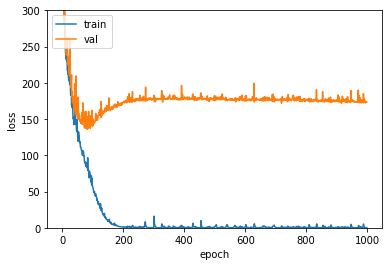

 32/100 [========>.....................] - ETA: 0s191.033380737


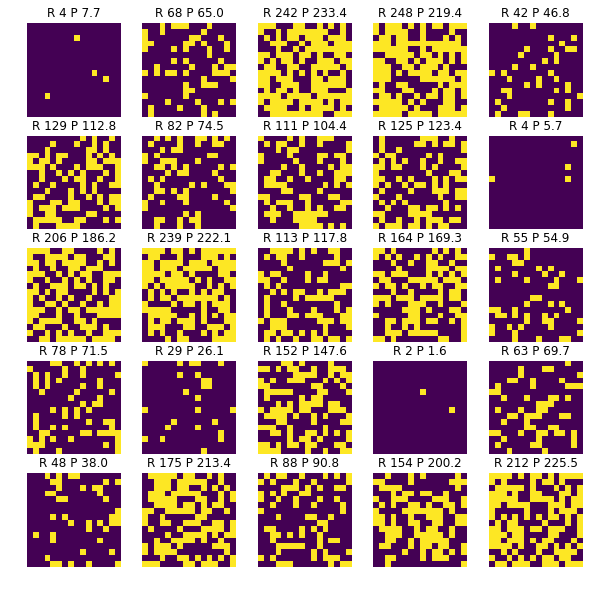

In [6]:
# 0. 사용할 패키지 불러오기
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

width = 16
height = 16

def generate_dataset(samples):

    ds_x = []
    ds_y = []
    
    for it in range(samples):
        
        num_pt = np.random.randint(0, width * height)
        img = generate_image(num_pt)
        
        ds_y.append(num_pt)
        ds_x.append(img)
    
    return np.array(ds_x), np.array(ds_y).reshape(samples, 1)
    
def generate_image(points):
    
    img = np.zeros((width, height))
    pts = np.random.random((points, 2))
    
    for ipt in pts:
        img[int(ipt[0] * width), int(ipt[1] * height)] = 1
    
    return img.reshape(width, height, 1)

# 1. 데이터셋 생성하기
x_train, y_train = generate_dataset(1500)
x_val, y_val = generate_dataset(300)
x_test, y_test = generate_dataset(100)

# 2. 모델 구성하기
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(width, height, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(1))

# 3. 모델 학습과정 설정하기
model.compile(loss='mse', optimizer='adam')

# 5. 모델 학습시키기
hist = model.fit(x_train, y_train, batch_size=32, epochs=1000, validation_data=(x_val, y_val))

# 6. 학습과정 살펴보기
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.ylim(0.0, 300.0)
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 7. 모델 평가하기
score = model.evaluate(x_test, y_test, batch_size=32)

print(score)

# 8. 모델 사용하기
yhat_test = model.predict(x_test, batch_size=32)

%matplotlib inline
import matplotlib.pyplot as plt

plt_row = 5
plt_col = 5

plt.rcParams["figure.figsize"] = (10,10)

f, axarr = plt.subplots(plt_row, plt_col)

for i in range(plt_row*plt_col):
    sub_plt = axarr[i/plt_row, i%plt_col]
    sub_plt.axis('off')
    sub_plt.imshow(x_test[i].reshape(width, height))
    sub_plt.set_title('R %d P %.1f' % (y_test[i][0], yhat_test[i][0]))

plt.show()

컨볼루션 신경망 모델이 예측한 결과 일부를 표시해봤습니다.

![img](http://tykimos.github.com/Keras/warehouse/2017-8-20-Image_Input_Numerical_Prediction_Model_Recipe_output_15_3.png)

---

### 학습결과 비교

다층퍼셉트론 신경망 모델와 컨볼루션 신경망 모델을 비교했을 때, 현재 파라미터로는 다층퍼셉트론 신경망 모델의 정확도가 더 높았습니다. 라벨값이 픽셀 간의 관계가 있거나 모양 및 색상이 다양하지 않고 단순히 1인 픽셀 개수와 관련이 있기 때문에 컨볼루션 신경망 모델이 크케 성능을 발휘하지 못했습니다. 

|다층퍼셉트론 신경망 모델|컨볼루션 신경망 모델|
|:-:|:-:|
|![img](http://tykimos.github.com/Keras/warehouse/2017-8-20-Image_Input_Numerical_Prediction_Model_Recipe_output_13_2.png)|![img](http://tykimos.github.com/Keras/warehouse/2017-8-20-Image_Input_Numerical_Prediction_Model_Recipe_output_15_1.png)|

---

### 요약

영상를 입력하여 수치예측을 할 수 있는 깊은 다층퍼셉트론 신경망 모델, 컨볼루션 신경망 모델을 살펴보고 그 성능을 확인 해봤습니다. 영상 입력이라고 해서 컨볼루션 신경망 모델이 항상 좋은 성능이 나오는 것이 아니라는 것도 알게되었습니다. 어떤 모델이 성능이 좋게 나올지는 테스트를 해봐야 겠지만, 워낙 모델을 다양하게 구성할 수 있고 여러 파라미터를 설정할 수 있으므로, 모델을 개발하기 전 데이터 특징을 분석하고 적절한 후보 모델들을 선정하는 것을 권장드립니다.

![img](http://tykimos.github.com/Keras/warehouse/2017-8-20-Image_Input_Numerical_Prediction_Model_Recipe_title.png)

---

### 같이 보기

* [강좌 목차](https://tykimos.github.io/Keras/lecture/)
* 이전 : [수치입력 다중클래스분류 모델 레시피](https://tykimos.github.io/Keras/2017/08/19/Numerical_Input_Multiclass_Classification_Model_Recipe/)
* 다음 : [영상입력 이진분류 모델 레시피](https://tykimos.github.io/Keras/2017/08/18/Image_Input_Binary_Classification_Model_Recipe/)